## O problema dos k-armed bandits

Se você está lendo isso é porque já sabe o que é o problema dos *k-armed bandits*, então vamos direto para o código.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Bandit():
    
    def __init__(self, k_arms=10):
        #k: aleatórios pertences a [-3,3]
        self.bandits_expectations = np.random.uniform(-3, 3, k_arms)
        
    def gamble(self, action):
        #action(int) -> reward(int)
        '''
        action = alavanca acionada, devolve reward baseada em uma
        distribuição normal de média definida no init e desvio padrão 1.
        '''
        return np.random.normal(self.bandits_expectations[action], 1)

Pela forma como o problema é acima montado, teremos alavancas que se distribuem normalmente, assim, a recompensa será fixa (no tempo) e necessariamente haverá uma alavanca melhor (que maximixa a recompensa) do que as outras. 

Assim, devemos descobrir qual a melhor alavanca.

### Algoritmo Guloso (Greedy)

Descobrir a melhor alavanca é descobrir o índice *k* que retorna na média a maior recompensa, assim, precisamos de uma função *argmax*:

(não usamos argmax do numpy pois o critério de desempate dele é de quem chegou primeiro)

In [3]:
from random import seed
from random import randint
import time

def argmax(vals):
    max = float("-inf")
    k_max = 0
    for i in range(len(vals)):
        if vals[i] > max:
            max = vals[i]
            k_max = i
        if vals[i] == max: #desempatando 'aleatoriamente' - não é a melhor forma de se fazer isso :D
            seed(time.time())
            value = randint(1, 2)
            if int(randint(0, 9)) % 2 == 0:
                max = vals[i]
                k_max = i
    return k_max

Agora sim construindo nosso agente guloso:

In [4]:
class GreedyAgent():
    def __init__(self, k_arms):
        self.n_arms = np.zeros(k_arms)
        self.Q_values = np.zeros(k_arms)
        self.last_action = np.random.randint(0, k_arms) #randint: [low, high), [0, low)
        
    def agent_step(self, reward):
        '''
        (float) -> action(int)
        Agente realiza um step: atualiza valores de Q.
        Pega recomensa do estado e retorna ação escolhida.
        '''
        
        #alavanca k foi utilizada
        self.n_arms[self.last_action] += 1
        
        step_size = 1/self.n_arms[self.last_action]
        #Qn+1 = Qn + (Rn-Qn)/n
        current_Q = self.Q_values[self.last_action] + step_size*(reward - self.Q_values[self.last_action])
        
        #atualiza Q_values
        self.Q_values[self.last_action] = current_Q
        
        #escolhe a próxima alavanca
        current_action = argmax(self.Q_values)
        self.last_action = current_action
        
        return current_action

### Treinando o agente.1

Com ambiente e agente definidos, podemos agora treiná-lo.

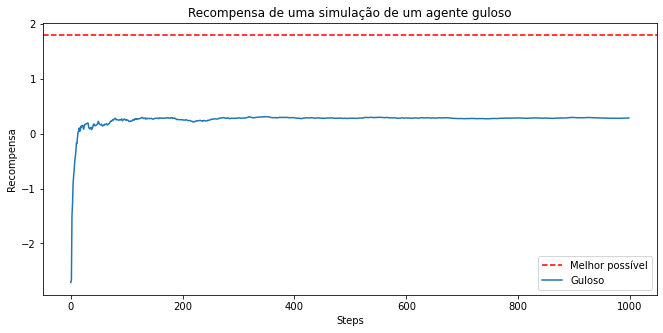

In [5]:
n_steps = 1000

agent = GreedyAgent(k_arms = 10)
env = Bandit(k_arms = 10)

score = [0]
means = []
max_score = np.max(env.bandits_expectations)

for step in range(n_steps - 1):
    #tomando ação no ambiente
    reward = env.gamble(agent.last_action)
    #atualizando a estimativa de valor do agente
    agent.last_action = agent.agent_step(reward)
    
    score.append(score[-1] + reward)
    means.append(score[-1]/(step+1))
    
plt.figure(figsize=(11,5))
plt.title("Recompensa de uma simulação de um agente guloso")
plt.axline((0, max_score), slope=0, ls="--", c="red", label="Melhor possível")
plt.plot(means, label="Guloso")
plt.xlabel("Steps")
plt.ylabel("Recompensa")
plt.legend(loc="best")
plt.show()

Como podemos ver acima, nosso agente guloso está aquém do ótimo (em alguns casos, com devida sorte, o agente guloso pode alcançar bons valores de recompensa). Para melhorar isso, precisamos executar várias simulações e pegar a média:

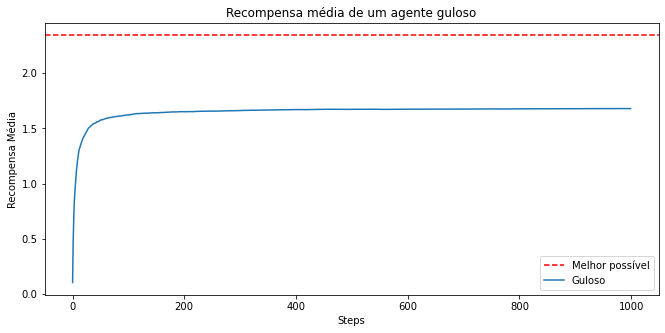

In [6]:
n_steps = 1000
n_simulations = 200
total_means = []

max_means = 0
for simulation in range(n_simulations):

    agent = GreedyAgent(k_arms = 10)
    env = Bandit(k_arms = 10)

    score = [0]
    means = []

    max_means += np.max(env.bandits_expectations)

    for step in range(n_steps):
        reward = env.gamble(agent.last_action)
        agent.last_action = agent.agent_step(reward)
    
        score.append(score[-1] + reward)
        means.append(score[-1]/(step+1))

    total_means.append(means)

plt.figure(figsize=(11,5))
plt.title("Recompensa média de um agente guloso")
plt.axline((0, max_means/n_simulations), slope=0, ls="--", c="red", label="Melhor possível")
plt.plot(np.mean(total_means, axis=0), label="Guloso")
plt.xlabel("Steps")
plt.ylabel("Recompensa Média")
plt.legend(loc="best")
plt.show()

Vemos acima que o agente guloso atinge rapidamente uma recompensa média relativamente alta, entretanto, ele não alcança o máximo potencial.

Para contornar isso, vamos criar o agente ε-Guloso, que possui a chance de fazer uma ção de exploração, assim, não se prende a atual alavanca de maior recompensa, mas também explora as alternativas, possivelmente encontrando alavancas melhores.

### Algoritmo ε-Guloso (ε-Greedy)

A sua construção será praticamente a mesma, o que muda é que implementaremos uma chance (**ε**) de o algoritmo, ao invés de escolher a alavanca correspondente ao *argmax* atual, escolher uma alavanca aleatoriamente - de forma a explorar novas opções.

In [12]:
class EpsilonGreedy():
    def __init__(self, k_arms, epsilon=0.1):
        self.epsilon = epsilon
        self.n_arms = k_arms
        self.k_arms = np.zeros(k_arms)
        self.Q_values = np.zeros(k_arms)
        self.last_action = np.random.randint(0, k_arms)
        
    def agent_step(self, reward):
        '''
        (float) -> action(int)
        Agente realiza um step: atualiza valores de Q.
        Pega recomensa do estado e retorna ação escolhida.
        '''
        
        self.k_arms[self.last_action] += 1
        
        step_size = 1/self.k_arms[self.last_action]
        current_Q = self.Q_values[self.last_action] + step_size*(reward - self.Q_values[self.last_action])
        
        self.Q_values[self.last_action] = current_Q
        
        #escolhendo a próxima alavanca:
        if np.random.random() < self.epsilon:
            current_action = np.random.randint(self.n_arms)
        else:
            current_action = argmax(self.Q_values)
        
        self.last_action = current_action
        
        return current_action

### Treinando o agente.2

Agora vamos treinar o agente, e fazê-lo para diferentes *epsilons*, assim podendo compará-los.

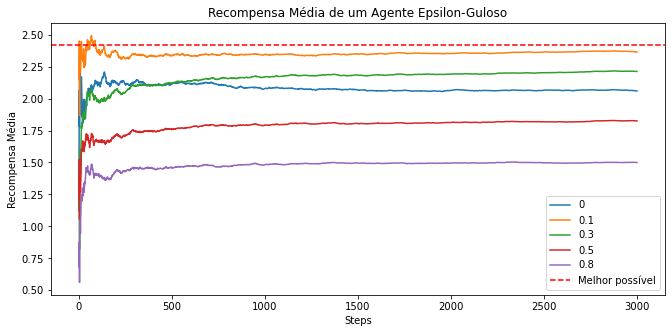

In [13]:
n_steps = 3_000
n_simulations = 20
total_means = []
max_means = []

epsilons = [0, 0.1, 0.3, 0.5, 0.8]

plt.figure(figsize=(11,5))

# Fazer 20 simulações, com 3.000 steps para cada epsilon eps
for eps in epsilons: 
    max_mean = 0
    for runs in range(n_simulations):

        agent = EpsilonGreedy(k_arms = 10, epsilon = eps)
        env = Bandit(k_arms = 10)
        score = [0]
        means = []

        max_mean += np.max(env.bandits_expectations)

        for step in range(n_steps):
            reward = env.gamble(agent.last_action)
            agent.last_action = agent.agent_step(reward)
            score.append(score[-1] + reward)
            means.append(score[-1]/(step+1))
        
    total_means.append(means)

    max_means.append(max_mean/n_simulations)
    
    plt.plot(np.mean(total_means, axis=0), label=f"{eps}")

y = np.mean(max_means, 0)
plt.axline((0, y), slope=0, ls="--", c="red", label="Melhor possível")
plt.legend(loc="best")
plt.title("Recompensa Média de um Agente Epsilon-Guloso")
plt.xlabel("Steps")
plt.ylabel("Recompensa Média")
plt.show()

Como podemos ver acima, vale a pena explorar diferentes valores de epsilon, sendo que para este problema, ε=0.1 foi o que alcançou a maior recompensa - provavelmente por se tratar de um problema simples, ele explora e encontra rápido o bastante a melhor alavanca, e sendo o que é mais guloso (sem contar ε=0), alcança os maiores valores.